<a href="https://colab.research.google.com/github/Simoni2412/Hyperpigmentation_detection/blob/main/H%26R_detection_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Skin Redness & Hyperpigmentation Detection with U-Net
COCO Format Annotations
"""

# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [3]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Starting Training...
Using device: cuda
Train samples: 511
Validation samples: 45


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/50
  Train Loss: 0.7292, Train Dice: 0.3743
  Val Loss: 0.5702, Val Dice: 0.4155
  ✓ Best model saved to /content/drive/MyDrive/Dataset/skin_unet_best.h5! (Dice: 0.4155)
Epoch 2/50
  Train Loss: 0.5300, Train Dice: 0.3676
  Val Loss: 0.5905, Val Dice: 0.3131
Epoch 3/50
  Train Loss: 0.4631, Train Dice: 0.3585
  Val Loss: 0.4031, Val Dice: 0.4316
  ✓ Best model saved to /content/drive/MyDrive/Dataset/skin_unet_best.h5! (Dice: 0.4316)
Epoch 4/50
  Train Loss: 0.4197, Train Dice: 0.3876
  Val Loss: 0.3740, Val Dice: 0.4312
Epoch 5/50
  Train Loss: 0.3907, Train Dice: 0.3557
  Val Loss: 0.3613, Val Dice: 0.4312
Epoch 6/50
  Train Loss: 0.3683, Train Dice: 0.3842
  Val Loss: 0.3156, Val Dice: 0.3762
Epoch 7/50
  Train Loss: 0.3555, Train Dice: 0.3717
  Val Loss: 0.3263, Val Dice: 0.4312
Epoch 8/50
  Train Loss: 0.3440, Train Dice: 0.3790
  Val Loss: 0.3314, Val Dice: 0.3757
Epoch 9/50
  Train Loss: 0.3381, Train Dice: 0.3898
  Val Loss: 0.2990, Val Dice: 0.4312
Epoch 10/50
  Train L

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


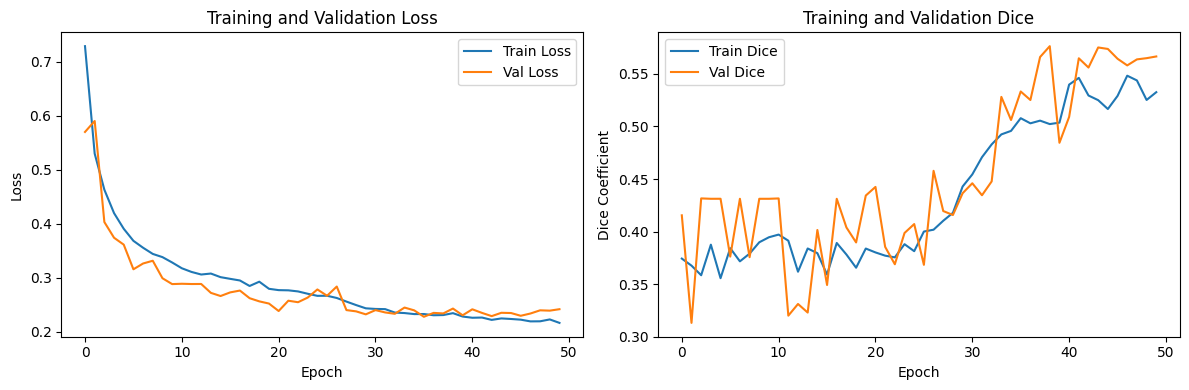

In [4]:
# ============================================================================
# 2. DATASET CLASS FOR COCO FORMAT
# ============================================================================

class COCOSkinDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None, img_size=256):
        """
        Args:
            image_dir: Directory with images
            annotation_file: Path to COCO format JSON file
            transform: Optional transform to be applied
            img_size: Target image size (height, width)
        """
        self.image_dir = image_dir
        self.img_size = img_size
        self.transform = transform

        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create image_id to filename mapping
        self.images = {img['id']: img for img in self.coco_data['images']}

        # Group annotations by image_id
        self.image_annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.image_annotations:
                self.image_annotations[img_id] = []
            self.image_annotations[img_id].append(ann)

        self.image_ids = list(self.image_annotations.keys())

        # Category mapping (redness, hyperpigmentation)
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]

        # Load image
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Create mask (multi-class: 0=background, 1=redness, 2=hyperpigmentation)
        mask = np.zeros((h, w), dtype=np.uint8)

        # Fill mask from COCO segmentation polygons
        for ann in self.image_annotations[img_id]:
            cat_id = ann['category_id']
            segmentation = ann['segmentation']

            for seg in segmentation:
                poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [poly], cat_id)

        # Resize
        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # Normalize image
        image = image.astype(np.float32) / 255.0

        # Convert to torch tensors
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
        mask = torch.from_numpy(mask).long()

        if self.transform:
            image = self.transform(image)

        return image, mask

# ============================================================================
# 3. U-NET ARCHITECTURE
# ============================================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Output
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)

# ============================================================================
# 4. TRAINING UTILITIES
# ============================================================================

def dice_coefficient(pred, target, num_classes=3):
    """Calculate Dice coefficient for each class"""
    dice_scores = []
    pred = torch.argmax(pred, dim=1)

    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union == 0:
            dice = 1.0
        else:
            dice = (2. * intersection) / (union + 1e-8)
            dice = dice.item() if torch.is_tensor(dice) else dice
        dice_scores.append(dice)

    return np.mean(dice_scores)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks)

    return total_loss / len(dataloader), total_dice / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks)

    return total_loss / len(dataloader), total_dice / len(dataloader)

# ============================================================================
# 5. MAIN TRAINING SCRIPT
# ============================================================================

def train_model(train_image_dir, train_annotation_file,
                val_image_dir, val_annotation_file,
                model_save_path='best_model.h5',
                num_epochs=50, batch_size=8, lr=1e-4, img_size=256):

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Datasets
    train_dataset = COCOSkinDataset(train_image_dir, train_annotation_file, img_size=img_size)
    val_dataset = COCOSkinDataset(val_image_dir, val_annotation_file, img_size=img_size)

    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=4)

    # Model
    model = UNet(n_channels=3, n_classes=3).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    # Training loop
    best_dice = 0.0
    history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}

    for epoch in range(num_epochs):
        train_loss, train_dice = train_epoch(model, train_loader, criterion,
                                            optimizer, device)
        val_loss, val_dice = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

        # Save best model in H5 format
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), model_save_path)
            print(f"  ✓ Best model saved to {model_save_path}! (Dice: {best_dice:.4f})")

    print(f"\nTraining completed! Best Dice: {best_dice:.4f}")
    print(f"Best model saved at: {model_save_path}")

    return model, history

# ============================================================================
# 6. TEST EVALUATION FUNCTION
# ============================================================================

def test_model(model_path, test_image_dir, test_annotation_file,
               batch_size=8, img_size=256):
    """Evaluate model on test dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = UNet(n_channels=3, n_classes=3).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from: {model_path}")

    # Test dataset
    test_dataset = COCOSkinDataset(test_image_dir, test_annotation_file, img_size=img_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=4)
    print(f"Test samples: {len(test_dataset)}")

    # Evaluate
    criterion = nn.CrossEntropyLoss()
    test_loss, test_dice = validate(model, test_loader, criterion, device)

    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Dice: {test_dice:.4f}")

    return test_loss, test_dice

# ============================================================================
# 7. INFERENCE FUNCTION
# ============================================================================

def inference(model_path, image_path, device='cuda', img_size=256):
    """Run inference on a single image"""
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # Load model
    model = UNet(n_channels=3, n_classes=3).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]

    image_resized = cv2.resize(image, (img_size, img_size))
    image_tensor = torch.from_numpy(image_resized.astype(np.float32) / 255.0)
    image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Resize back to original size
    pred_mask = cv2.resize(pred_mask, (original_size[1], original_size[0]),
                          interpolation=cv2.INTER_NEAREST)

    return pred_mask

def visualize_prediction(image_path, pred_mask):
    """Visualize prediction with colored overlay"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create colored mask
    color_mask = np.zeros_like(image)
    color_mask[pred_mask == 1] = [255, 0, 0]      # Red for redness
    color_mask[pred_mask == 2] = [139, 69, 19]    # Brown for hyperpigmentation

    # Overlay
    overlay = cv2.addWeighted(image, 0.7, color_mask, 0.3, 0)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(pred_mask, cmap='tab10')
    axes[1].set_title('Prediction Mask')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================================================
# 8. USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":

    # ========== TRAINING ==========
    print("Starting Training...")

    # Paths
    TRAIN_IMAGE_DIR = "/content/drive/MyDrive/Dataset/train"
    TRAIN_ANNOTATION_FILE = "/content/drive/MyDrive/Dataset/train/filtered_annotations.coco.json"
    VAL_IMAGE_DIR = "/content/drive/MyDrive/Dataset/valid"
    VAL_ANNOTATION_FILE = "/content/drive/MyDrive/Dataset/valid/filtered_annotations.coco.json"
    MODEL_SAVE_PATH = "/content/drive/MyDrive/Dataset/skin_unet_best.h5"

    # Train
    model, history = train_model(
        train_image_dir=TRAIN_IMAGE_DIR,
        train_annotation_file=TRAIN_ANNOTATION_FILE,
        val_image_dir=VAL_IMAGE_DIR,
        val_annotation_file=VAL_ANNOTATION_FILE,
        model_save_path=MODEL_SAVE_PATH,
        num_epochs=50,
        batch_size=8,
        lr=1e-4,
        img_size=256
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Training and Validation Dice')
    plt.tight_layout()
    plt.savefig('./training_history.png')

    # ========== TEST EVALUATION ==========
    print("\n" + "="*50)
    print("Evaluating on Test Set...")

    TEST_IMAGE_DIR = "/content/drive/MyDrive/Dataset/test"
    TEST_ANNOTATION_FILE = "/content/drive/MyDrive/Dataset/test/filtered_annotations.coco.json"

    test_loss, test_dice = test_model(
        model_path=MODEL_SAVE_PATH,
        test_image_dir=TEST_IMAGE_DIR,
        test_annotation_file=TEST_ANNOTATION_FILE,
        batch_size=8,
        img_size=256
    )

    # ========== INFERENCE ==========
    print("\n" + "="*50)
    print("Running Inference on Sample Image...")

    TEST_IMAGE = "./sample_test_image.jpg"

    # Run inference
    pred_mask = inference(MODEL_SAVE_PATH, TEST_IMAGE)

    # Visualize
    visualize_prediction(TEST_IMAGE, pred_mask)

    print("\nDone!")